RBF and MMDLoss classes are copied from https://github.com/yiftachbeer/mmd_loss_pytorch with some changes

In [82]:
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm 

In [83]:
class RBF(nn.Module):

    def __init__(self, bandwidth=None): #bandwidth = sigma
        super().__init__()
        self.bandwidth_multipliers = torch.tensor([0.5, 1, 5, 10, 20, 40], dtype = torch.float32)
        self.bandwidth = bandwidth

    def get_bandwidth(self):
        if self.bandwidth is None:
            return 1
        return self.bandwidth

    def forward(self, X):
        L2_distances = torch.cdist(X, X) ** 2 
        return torch.exp(-0.5 * L2_distances[None, ...] / ((self.get_bandwidth() * self.bandwidth_multipliers)**2)[:, None, None]).sum(dim=0) - 6*torch.eye(len(X), dtype=torch.float32)

class MMDLoss(nn.Module):

    def __init__(self, kernel=RBF()):
        super().__init__()
        self.kernel = kernel

    def forward(self, X, Y):
        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        Y_size = Y.shape[0]
        XX = K[:X_size, :X_size].sum() / (X_size**2-X_size)
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].sum() / (Y_size**2-Y_size)
        return XX - 2 * XY + YY 
    
class Laplacian(nn.Module):

    def __init__(self, bandwidth=None): #bandwidth = gamma
        super().__init__()
        self.bandwidth_multipliers = torch.tensor([0.5, 1, 5, 10, 20, 40], dtype = torch.float32)
        self.bandwidth = bandwidth

    def get_bandwidth(self):
        if self.bandwidth is None:
            return 1
        return self.bandwidth

    def forward(self, X):
        L1_distances = torch.cdist(X, X, p = 1) 
        return torch.exp(-L1_distances[None, ...] * (self.get_bandwidth() * self.bandwidth_multipliers)[:, None, None]).sum(dim=0) - 6*torch.eye(len(X), dtype=torch.float32)
    

class RQ(nn.Module):

    def __init__(self):
        super().__init__()
        self.alpha = torch.tensor([0.25,0.5,1,2,5,10], dtype = torch.float32)

    def forward(self, X):
        L2_distances = torch.cdist(X, X) ** 2 
        return ((1+L2_distances[None, ...] / (2 * self.alpha)[:, None, None])**-self.alpha[:,None,None]).sum(dim=0) - 6*torch.eye(len(X), dtype=torch.float32)
    
class EnergyDistance(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, X, Y):
        data = torch.vstack([X, Y])
        L2_distances = torch.cdist(data, data)

        X_size = X.shape[0]
        Y_size = Y.shape[0]
        XX = L2_distances[:X_size, :X_size].sum()/(X_size**2-X_size)
        XY = L2_distances[:X_size, X_size:].mean()
        YY = L2_distances[X_size:, X_size:].sum()/(Y_size**2-Y_size)
        return -0.5*XX + XY -0.5*YY

Training data:

In [85]:
np.random.seed(0)

N = 20000 #number of training data
x1 = np.random.normal(0,5,N) #N(0,25)
x2 = np.random.normal(3,1,N)
y = 2*x1 + x2 + np.random.normal(0,1,N)
X_input = np.column_stack((x1,x2))

X_input = torch.tensor(X_input, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

#standardize data
X_means = X_input.mean(dim=0, keepdim=True)
X_stds = X_input.std(dim=0, keepdim=True)
X_input_scaled = (X_input - X_means) / X_stds

Define and train MMD network with RBF kernel:

In [88]:
np.random.seed(1)
torch.manual_seed(0)

N_input = 100 #number of uniform inputs
class network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(X_input_scaled.shape[1]+N_input, 200)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(200, 200)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(200, 100)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(100, 100)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(100, 1)

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.output(x)
        return x
    
model = network()

loss_fn = MMDLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

n_epochs = 150
batch_size = 400

for epoch in range(n_epochs):
    shuffle = torch.randperm(len(y))
    y = y[shuffle]
    X_input_scaled = X_input_scaled[shuffle]
    X_input = X_input[shuffle]
    for i in range(0, len(y), batch_size):
        Xbatch = X_input_scaled[i:i+batch_size]
        x = np.random.uniform(-0.5,0.5,batch_size*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(batch_size, N_input)
        X_model = torch.column_stack([Xbatch,x])
        y_pred = model(X_model) #generated data
        ybatch = y[i:i+batch_size] #real data
        Xunscaledbatch = X_input[i:i+batch_size]
        pred = torch.column_stack([Xunscaledbatch,y_pred])
        real = torch.column_stack([Xunscaledbatch,ybatch])
        loss = loss_fn(pred, real)
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.018397092819213867
Finished epoch 1, latest loss 0.0005681514739990234
Finished epoch 2, latest loss -0.0047795772552490234
Finished epoch 3, latest loss -0.0036554336547851562
Finished epoch 4, latest loss -0.002237558364868164
Finished epoch 5, latest loss -0.004952907562255859
Finished epoch 6, latest loss -0.008889436721801758
Finished epoch 7, latest loss -0.011455774307250977
Finished epoch 8, latest loss -0.005341529846191406
Finished epoch 9, latest loss -0.009070158004760742
Finished epoch 10, latest loss -0.005965709686279297
Finished epoch 11, latest loss -0.005853891372680664
Finished epoch 12, latest loss -0.010507345199584961
Finished epoch 13, latest loss -0.010146617889404297
Finished epoch 14, latest loss -0.012504100799560547
Finished epoch 15, latest loss -0.009675025939941406
Finished epoch 16, latest loss -0.009424209594726562
Finished epoch 17, latest loss -0.00785517692565918
Finished epoch 18, latest loss -0.0015635490417480469
Fi

Train MMD network with laplacian Kernel:

In [92]:
np.random.seed(1)
torch.manual_seed(0)
    
model_Laplacian = network()

loss_fn_Laplacian = MMDLoss(kernel=Laplacian())
optimizer_Laplacian = optim.RMSprop(model_Laplacian.parameters(), lr=0.001)

n_epochs = 150
batch_size = 400

for epoch in range(n_epochs):
    shuffle = torch.randperm(len(y))
    y = y[shuffle]
    X_input_scaled = X_input_scaled[shuffle]
    X_input = X_input[shuffle]
    for i in range(0, len(y), batch_size):
        Xbatch = X_input_scaled[i:i+batch_size]
        x = np.random.uniform(-0.5,0.5,batch_size*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(batch_size, N_input)
        X_model = torch.column_stack([Xbatch,x])
        y_pred = model_Laplacian(X_model)
        ybatch = y[i:i+batch_size]
        Xunscaledbatch = X_input[i:i+batch_size]
        pred = torch.column_stack([Xunscaledbatch,y_pred])
        real = torch.column_stack([Xunscaledbatch,ybatch])
        loss = loss_fn_Laplacian(pred, real)
        optimizer_Laplacian.zero_grad()
        loss.backward() 
        optimizer_Laplacian.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.002155303955078125
Finished epoch 1, latest loss -0.0019259601831436157
Finished epoch 2, latest loss -0.0029245391488075256
Finished epoch 3, latest loss -0.004279758781194687
Finished epoch 4, latest loss -0.005146641284227371
Finished epoch 5, latest loss -0.004755798727273941
Finished epoch 6, latest loss -0.00366964191198349
Finished epoch 7, latest loss -0.0030040517449378967
Finished epoch 8, latest loss -0.005366120487451553
Finished epoch 9, latest loss -0.005988851189613342
Finished epoch 10, latest loss -0.0049491338431835175
Finished epoch 11, latest loss -0.00510966032743454
Finished epoch 12, latest loss -0.00414421409368515
Finished epoch 13, latest loss -0.003018423914909363
Finished epoch 14, latest loss -0.004851475358009338
Finished epoch 15, latest loss -0.0036274343729019165
Finished epoch 16, latest loss -0.0029354244470596313
Finished epoch 17, latest loss -0.004437834024429321
Finished epoch 18, latest loss -0.005861297249794006
F

Train MMD network with RQ kernel:

In [93]:
np.random.seed(1)
torch.manual_seed(0)
    
model_RQ = network()

loss_fn_RQ = MMDLoss(kernel=RQ())
optimizer_RQ = optim.RMSprop(model_RQ.parameters(), lr=0.001)

n_epochs = 150
batch_size = 400

for epoch in range(n_epochs):
    shuffle = torch.randperm(len(y))
    y = y[shuffle]
    X_input_scaled = X_input_scaled[shuffle]
    X_input = X_input[shuffle]
    for i in range(0, len(y), batch_size):
        Xbatch = X_input_scaled[i:i+batch_size]
        x = np.random.uniform(-0.5,0.5,batch_size*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(batch_size, N_input)
        X_model = torch.column_stack([Xbatch,x])
        y_pred = model_RQ(X_model)
        ybatch = y[i:i+batch_size]
        Xunscaledbatch = X_input[i:i+batch_size]
        pred = torch.column_stack([Xunscaledbatch,y_pred])
        real = torch.column_stack([Xunscaledbatch,ybatch])
        loss = loss_fn_RQ(pred, real)
        optimizer_RQ.zero_grad()
        loss.backward() 
        optimizer_RQ.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.015301764011383057
Finished epoch 1, latest loss 0.00013273954391479492
Finished epoch 2, latest loss -0.007809817790985107
Finished epoch 3, latest loss -0.01425623893737793
Finished epoch 4, latest loss -0.012337088584899902
Finished epoch 5, latest loss -0.015367686748504639
Finished epoch 6, latest loss -0.01097041368484497
Finished epoch 7, latest loss -0.017398178577423096
Finished epoch 8, latest loss -0.009264707565307617
Finished epoch 9, latest loss -0.01630580425262451
Finished epoch 10, latest loss -0.016164422035217285
Finished epoch 11, latest loss -0.015158355236053467
Finished epoch 12, latest loss -0.016545653343200684
Finished epoch 13, latest loss -0.018000423908233643
Finished epoch 14, latest loss -0.016024231910705566
Finished epoch 15, latest loss -0.01682060956954956
Finished epoch 16, latest loss -0.01810997724533081
Finished epoch 17, latest loss -0.01536715030670166
Finished epoch 18, latest loss -0.01014643907546997
Finished e

Train energy distance network:

In [94]:
np.random.seed(1)
torch.manual_seed(0)
    
model_ED = network()

loss_fn_ED = EnergyDistance()
optimizer_ED = optim.RMSprop(model_ED.parameters(), lr=0.001)

n_epochs = 150 #150
batch_size = 400

for epoch in range(n_epochs):
    shuffle = torch.randperm(len(y))
    y = y[shuffle]
    X_input_scaled = X_input_scaled[shuffle]
    X_input = X_input[shuffle]
    for i in range(0, len(y), batch_size):
        Xbatch = X_input_scaled[i:i+batch_size]
        x = np.random.uniform(-0.5,0.5,batch_size*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(batch_size, N_input)
        X_model = torch.column_stack([Xbatch,x])
        y_pred = model_ED(X_model)
        ybatch = y[i:i+batch_size]
        Xunscaledbatch = X_input[i:i+batch_size]
        pred = torch.column_stack([Xunscaledbatch,y_pred])
        real = torch.column_stack([Xunscaledbatch,ybatch])
        loss = loss_fn_ED(pred, real)
        optimizer_ED.zero_grad()
        loss.backward() 
        optimizer_ED.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.022196292877197266
Finished epoch 1, latest loss -0.018082618713378906
Finished epoch 2, latest loss -0.023011207580566406
Finished epoch 3, latest loss -0.021807193756103516
Finished epoch 4, latest loss -0.026890277862548828
Finished epoch 5, latest loss -0.028263092041015625
Finished epoch 6, latest loss -0.024021625518798828
Finished epoch 7, latest loss -0.021449565887451172
Finished epoch 8, latest loss -0.02563762664794922
Finished epoch 9, latest loss -0.017740249633789062
Finished epoch 10, latest loss -0.02223348617553711
Finished epoch 11, latest loss -0.02956676483154297
Finished epoch 12, latest loss -0.010625839233398438
Finished epoch 13, latest loss -0.013708114624023438
Finished epoch 14, latest loss -0.02650737762451172
Finished epoch 15, latest loss -0.010551929473876953
Finished epoch 16, latest loss -0.026766300201416016
Finished epoch 17, latest loss -0.030249595642089844
Finished epoch 18, latest loss -0.022873401641845703
Finished

Test the four models.
Compute MSE for mean, sd and quantiles, mean MMDs and energy distance, MAE for mean, sd, number of rejected t tests for mean, number of rejected Kolmonogorov-Smirnov tests for normality.

MMD network with RBF kernel:

In [122]:
np.random.seed(2)

MSE_means = []
MSE_stds =[]
MSE_quantiles = []
MSE_quantiles10 = []
MAE_means = []
MAE_stds = []
MMD_RBF = []
MMD_Laplacian = []
MMD_RQ = []
ED = []
mean_reject = 0
normal_reject = 0
n = 0
sd_lower = 0
for i in np.arange(-10,10.2,0.2):
    for j in np.arange(1,5.2,0.2):
        x = np.random.uniform(-0.5,0.5,1000*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
        X_predict = torch.tensor([i,j]*1000, dtype=torch.float32).reshape(1000,2)
        X_predict = (X_predict - X_means) / X_stds
        X_predict = torch.column_stack([X_predict,x])
        with torch.no_grad():
            y_sample = model(X_predict)
        y_compare = 2*i + j + np.random.normal(0,1,1000) #samples from real distribution
        y_compare = torch.tensor(y_compare, dtype=torch.float32).reshape(-1, 1)
        MMD_RBF.append(loss_fn(y_sample,y_compare))
        MMD_Laplacian.append(loss_fn_Laplacian(y_sample,y_compare))
        MMD_RQ.append(loss_fn_RQ(y_sample,y_compare))
        ED.append(loss_fn_ED(y_sample,y_compare))
        y_sample = y_sample.reshape(1,-1).numpy()[0]
        MSE_means.append((2*i+j - np.mean(y_sample))**2)
        MAE_means.append(np.sqrt((2*i+j - np.mean(y_sample))**2))
        MSE_stds.append((1-np.std(y_sample))**2)
        MAE_stds.append(np.sqrt((1-np.std(y_sample))**2))
        MSE_quantiles.append((stats.norm.ppf(0.9, loc=2*i+j, scale=1)-np.quantile(y_sample,0.9))**2)
        MSE_quantiles10.append((stats.norm.ppf(0.1, loc=2*i+j, scale=1)-np.quantile(y_sample,0.1))**2)
        mean_pvalue = stats.ttest_1samp(y_sample, popmean=2*i+j).pvalue
        if mean_pvalue < 0.05: mean_reject += 1
        normal_pvalue = stats.kstest(y_sample, stats.norm(loc=2*i+j,scale=1).cdf).pvalue
        if normal_pvalue < 0.05: normal_reject += 1
        if np.std(y_sample) < 1: sd_lower += 1
        n += 1

print(f'MSE of means: {np.mean(MSE_means)}')
print(f'MSE of standard deviations: {np.mean(MSE_stds)}')
print(f'MSE of 0.9 quantiles: {np.mean(MSE_quantiles)}')
print(f'MSE of 0.1 quantiles: {np.mean(MSE_quantiles10)}')
print(f'MMD with RBF kernel: {np.mean(MMD_RBF)}')
print(f'MMD with Laplacian kernel: {np.mean(MMD_Laplacian)}')
print(f'MMD with RQ kernel: {np.mean(MMD_RQ)}')
print(f'Energy distance: {np.mean(ED)}')
print(f'MAE of means: {np.mean(MAE_means)}')
print(f'MAE of standard deviations: {np.mean(MAE_stds)}')
print(f'Number of rejected null, mean is not correct mean: {mean_reject}, {100*mean_reject/n}%') 
print(f'Number of rejected null, dist is normal (Kolmonogorov-Smirnov): {normal_reject}, {100*normal_reject/n}%') 
print(f'Number of lower sd than real: {100*sd_lower/n}%') 

MSE of means: 0.017824697153633093
MSE of standard deviations: 0.029753585811603707
MSE of 0.9 quantiles: 0.08407772626159304
MSE of 0.1 quantiles: 0.051177871744551066
MMD with RBF kernel: 0.02102157473564148
MMD with Laplacian kernel: 0.021862927824258804
MMD with RQ kernel: 0.04537883400917053
Energy distance: 0.009582926519215107
MAE of means: 0.0970872004882691
MAE of standard deviations: 0.16436579484863137
Number of rejected null, mean is not correct mean: 1155, 54.45544554455446%
Number of rejected null, dist is normal (Kolmonogorov-Smirnov): 2098, 98.91560584629892%
Number of lower sd than real: 100.0%


MMD network with laplacian kernel:

In [123]:
np.random.seed(2)

MSE_means = []
MSE_stds =[]
MSE_quantiles = []
MSE_quantiles10 = []
MAE_means = []
MAE_stds = []
MMD_RBF = []
MMD_Laplacian = []
MMD_RQ = []
ED = []
mean_reject = 0
normal_reject = 0
n = 0
sd_lower = 0
for i in np.arange(-10,10.2,0.2):
    for j in np.arange(1,5.2,0.2):
        x = np.random.uniform(-0.5,0.5,1000*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
        X_predict = torch.tensor([i,j]*1000, dtype=torch.float32).reshape(1000,2)
        X_predict = (X_predict - X_means) / X_stds
        X_predict = torch.column_stack([X_predict,x])
        with torch.no_grad():
            y_sample = model_Laplacian(X_predict)
        y_compare = 2*i + j + np.random.normal(0,1,1000)
        y_compare = torch.tensor(y_compare, dtype=torch.float32).reshape(-1, 1)
        MMD_RBF.append(loss_fn(y_sample,y_compare))
        MMD_Laplacian.append(loss_fn_Laplacian(y_sample,y_compare))
        MMD_RQ.append(loss_fn_RQ(y_sample,y_compare))
        ED.append(loss_fn_ED(y_sample,y_compare))
        y_sample = y_sample.reshape(1,-1).numpy()[0]
        MSE_means.append((2*i+j - np.mean(y_sample))**2)
        MAE_means.append(np.sqrt((2*i+j - np.mean(y_sample))**2))
        MSE_stds.append((1-np.std(y_sample))**2)
        MAE_stds.append(np.sqrt((1-np.std(y_sample))**2))
        MSE_quantiles.append((stats.norm.ppf(0.9, loc=2*i+j, scale=1)-np.quantile(y_sample,0.9))**2)
        MSE_quantiles10.append((stats.norm.ppf(0.1, loc=2*i+j, scale=1)-np.quantile(y_sample,0.1))**2)
        mean_pvalue = stats.ttest_1samp(y_sample, popmean=2*i+j).pvalue
        if mean_pvalue < 0.05: mean_reject += 1
        normal_pvalue = stats.kstest(y_sample, stats.norm(loc=2*i+j,scale=1).cdf).pvalue
        if normal_pvalue < 0.05: normal_reject += 1
        if np.std(y_sample) < 1: sd_lower += 1
        n += 1

print(f'MSE of means: {np.mean(MSE_means)}')
print(f'MSE of standard deviations: {np.mean(MSE_stds)}')
print(f'MSE of 0.9 quantiles: {np.mean(MSE_quantiles)}')
print(f'MSE of 0.1 quantiles: {np.mean(MSE_quantiles10)}')
print(f'MMD with RBF kernel: {np.mean(MMD_RBF)}')
print(f'MMD with Laplacian kernel: {np.mean(MMD_Laplacian)}')
print(f'MMD with RQ kernel: {np.mean(MMD_RQ)}')
print(f'Energy distance: {np.mean(ED)}')
print(f'MAE of means: {np.mean(MAE_means)}')
print(f'MAE of standard deviations: {np.mean(MAE_stds)}')
print(f'Number of rejected null, mean is not correct mean: {mean_reject}, {100*mean_reject/n}%') 
print(f'Number of rejected null, dist is normal (Kolmonogorov-Smirnov): {normal_reject}, {100*normal_reject/n}%') 
print(f'Number of lower sd than real: {100*sd_lower/n}%') 

MSE of means: 0.08325208468076964
MSE of standard deviations: 0.018342178925508212
MSE of 0.9 quantiles: 0.05545940134450304
MSE of 0.1 quantiles: 0.17326765759448085
MMD with RBF kernel: 0.043770451098680496
MMD with Laplacian kernel: 0.042778920382261276
MMD with RQ kernel: 0.10070542991161346
Energy distance: 0.02720152959227562
MAE of means: 0.22209220002085006
MAE of standard deviations: 0.11211052122457811
Number of rejected null, mean is not correct mean: 1804, 85.05421970768505%
Number of rejected null, dist is normal (Kolmonogorov-Smirnov): 1927, 90.85337105139085%
Number of lower sd than real: 86.28005657708628%


MMD network with RQ kernel:

In [97]:
np.random.seed(2)

MSE_means = []
MSE_stds =[]
MSE_quantiles = []
MSE_quantiles10 = []
MAE_means = []
MAE_stds = []
MMD_RBF = []
MMD_Laplacian = []
MMD_RQ = []
ED =[]
mean_reject = 0
normal_reject = 0
n = 0
for i in np.arange(-10,10.2,0.2):
    for j in np.arange(1,5.2,0.2):
        x = np.random.uniform(-0.5,0.5,1000*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
        X_predict = torch.tensor([i,j]*1000, dtype=torch.float32).reshape(1000,2)
        X_predict = (X_predict - X_means) / X_stds
        X_predict = torch.column_stack([X_predict,x])
        with torch.no_grad():
            y_sample = model_RQ(X_predict)
        y_compare = 2*i + j + np.random.normal(0,1,1000)
        y_compare = torch.tensor(y_compare, dtype=torch.float32).reshape(-1, 1)
        MMD_RBF.append(loss_fn(y_sample,y_compare))
        MMD_Laplacian.append(loss_fn_Laplacian(y_sample,y_compare))
        MMD_RQ.append(loss_fn_RQ(y_sample,y_compare))
        ED.append(loss_fn_ED(y_sample,y_compare))
        y_sample = y_sample.reshape(1,-1).numpy()[0]
        MSE_means.append((2*i+j - np.mean(y_sample))**2)
        MAE_means.append(np.sqrt((2*i+j - np.mean(y_sample))**2))
        MSE_stds.append((1-np.std(y_sample))**2)
        MAE_stds.append(np.sqrt((1-np.std(y_sample))**2))
        MSE_quantiles.append((stats.norm.ppf(0.9, loc=2*i+j, scale=1)-np.quantile(y_sample,0.9))**2)
        MSE_quantiles10.append((stats.norm.ppf(0.1, loc=2*i+j, scale=1)-np.quantile(y_sample,0.1))**2)
        mean_pvalue = stats.ttest_1samp(y_sample, popmean=2*i+j).pvalue
        if mean_pvalue < 0.05: mean_reject += 1
        normal_pvalue = stats.kstest(y_sample, stats.norm(loc=2*i+j,scale=1).cdf).pvalue
        if normal_pvalue < 0.05: normal_reject += 1
        n += 1

print(f'MSE of means: {np.mean(MSE_means)}')
print(f'MSE of standard deviations: {np.mean(MSE_stds)}')
print(f'MSE of 0.9 quantiles: {np.mean(MSE_quantiles)}')
print(f'MSE of 0.1 quantiles: {np.mean(MSE_quantiles10)}')
print(f'MMD with RBF kernel: {np.mean(MMD_RBF)}')
print(f'MMD with Laplacian kernel: {np.mean(MMD_Laplacian)}')
print(f'MMD with RQ kernel: {np.mean(MMD_RQ)}')
print(f'Energy distance: {np.mean(ED)}')
print(f'MAE of means: {np.mean(MAE_means)}')
print(f'MAE of standard deviations: {np.mean(MAE_stds)}')
print(f'Number of rejected null, mean is not correct mean: {mean_reject}, {100*mean_reject/n}%') 
print(f'Number of rejected null, dist is normal (Kolmonogorov-Smirnov): {normal_reject}, {100*normal_reject/n}%') 

MSE of means: 0.020284352111134045
MSE of standard deviations: 0.05502588080824035
MSE of 0.9 quantiles: 0.12519746776457377
MSE of 0.1 quantiles: 0.09738484449225406
MMD with RBF kernel: 0.036603596061468124
MMD with Laplacian kernel: 0.03867991641163826
MMD with RQ kernel: 0.07621338218450546
Energy distance: 0.014837995171546936
MAE of means: 0.11950668303754675
MAE of standard deviations: 0.22515246045864848
Number of rejected null, mean is not correct mean: 1677, 79.06647807637907%
Number of rejected null, dist is normal (Kolmonogorov-Smirnov): 2121, 100.0%


Energy distance network:

In [98]:
np.random.seed(2)

MSE_means = []
MSE_stds =[]
MSE_quantiles = []
MSE_quantiles10 = []
MAE_means = []
MAE_stds = []
MMD_RBF = []
MMD_Laplacian = []
MMD_RQ = []
ED = []
mean_reject = 0
normal_reject = 0
n = 0
for i in np.arange(-10,10.2,0.2):
    for j in np.arange(1,5.2,0.2):
        x = np.random.uniform(-0.5,0.5,1000*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
        X_predict = torch.tensor([i,j]*1000, dtype=torch.float32).reshape(1000,2)
        X_predict = (X_predict - X_means) / X_stds
        X_predict = torch.column_stack([X_predict,x])
        with torch.no_grad(): 
            y_sample = model_ED(X_predict)
        y_compare = 2*i + j + np.random.normal(0,1,1000)
        y_compare = torch.tensor(y_compare, dtype=torch.float32).reshape(-1, 1)
        MMD_RBF.append(loss_fn(y_sample,y_compare))
        MMD_Laplacian.append(loss_fn_Laplacian(y_sample,y_compare))
        MMD_RQ.append(loss_fn_RQ(y_sample,y_compare))
        ED.append(loss_fn_ED(y_sample,y_compare))
        y_sample = y_sample.reshape(1,-1).numpy()[0]
        MSE_means.append((2*i+j - np.mean(y_sample))**2)
        MAE_means.append(np.sqrt((2*i+j - np.mean(y_sample))**2))
        MSE_stds.append((1-np.std(y_sample))**2)
        MAE_stds.append(np.sqrt((1-np.std(y_sample))**2))
        MSE_quantiles.append((stats.norm.ppf(0.9, loc=2*i+j, scale=1)-np.quantile(y_sample,0.9))**2)
        MSE_quantiles10.append((stats.norm.ppf(0.1, loc=2*i+j, scale=1)-np.quantile(y_sample,0.1))**2)
        mean_pvalue = stats.ttest_1samp(y_sample, popmean=2*i+j).pvalue
        if mean_pvalue < 0.05: mean_reject += 1
        normal_pvalue = stats.kstest(y_sample, stats.norm(loc=2*i+j,scale=1).cdf).pvalue
        if normal_pvalue < 0.05: normal_reject += 1
        n += 1

print(f'MSE of means: {np.mean(MSE_means)}')
print(f'MSE of standard deviations: {np.mean(MSE_stds)}')
print(f'MSE of 0.9 quantiles: {np.mean(MSE_quantiles)}')
print(f'MSE of 0.1 quantiles: {np.mean(MSE_quantiles10)}')
print(f'MMD with RBF kernel: {np.mean(MMD_RBF)}')
print(f'MMD with Laplacian kernel: {np.mean(MMD_Laplacian)}')
print(f'MMD with RQ kernel: {np.mean(MMD_RQ)}')
print(f'Energy distance: {np.mean(ED)}')
print(f'MAE of means: {np.mean(MAE_means)}')
print(f'MAE of standard deviations: {np.mean(MAE_stds)}')
print(f'Number of rejected null, mean is not correct mean: {mean_reject}, {100*mean_reject/n}%') 
print(f'Number of rejected null, dist is normal (Kolmonogorov-Smirnov): {normal_reject}, {100*normal_reject/n}%') 

MSE of means: 0.1328322914457635
MSE of standard deviations: 0.032752860250273866
MSE of 0.9 quantiles: 0.2695466243597677
MSE of 0.1 quantiles: 0.10673222588042336
MMD with RBF kernel: 0.07330664992332458
MMD with Laplacian kernel: 0.07199693471193314
MMD with RQ kernel: 0.16772344708442688
Energy distance: 0.04460682347416878
MAE of means: 0.28496583413530874
MAE of standard deviations: 0.16242300784008956
Number of rejected null, mean is not correct mean: 1898, 89.48609146628948%
Number of rejected null, dist is normal (Kolmonogorov-Smirnov): 2115, 99.71711456859971%


Compare to OLS linear regression:

In [ ]:
from sklearn.linear_model import LinearRegression

X_input_lr = X_input.numpy()
y_lr = y.numpy()
print(X_input_lr)
print(y_lr)
reg = LinearRegression().fit(X_input_lr, y_lr)

MSE = []
for i in np.arange(-10,10.2,0.2): #[-7,7]
    for j in np.arange(1,5.2,0.2):
        value = reg.predict(np.array([[i, j]]))
        MSE.append((2*i+j-value)**2)
print(np.mean(MSE))

Plot histogram and Q-Q plot for specific predictors
Can change predictors and model

[-14.394077 -15.153147 -16.170654 -14.597254 -15.545088 -15.047976
 -16.329304 -15.843843 -16.601234]


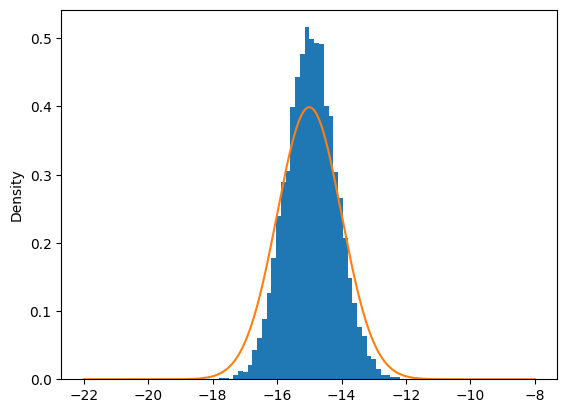

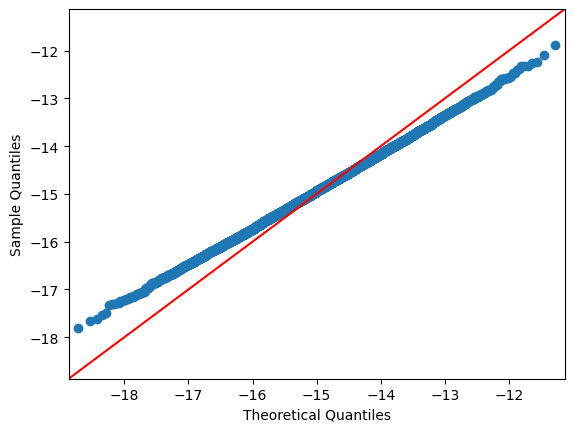

-14.940981
0.7799425


In [129]:
np.random.seed(2)

x = np.random.uniform(-0.5,0.5,10000*N_input)
x = torch.tensor(x, dtype=torch.float32).reshape(10000, N_input)
X_predict = torch.tensor([-10,5]*10000, dtype=torch.float32).reshape(10000,2)
X_predict = (X_predict - X_means) / X_stds
X_predict = torch.column_stack([X_predict,x])

with torch.no_grad():
    y_sample = model(X_predict)

y_sample = y_sample.reshape(1,-1).numpy()[0]
print(y_sample[1:10])

#histogram
plt.hist(y_sample, bins = 40, density=True) 
x_axis = np.arange(-22,-8, 0.001) #mean +/- 7
plt.plot(x_axis, norm.pdf(x_axis, -15, 1)) 
plt.ylabel("Density")
plt.show()

#qq plot
sm.qqplot(y_sample, norm, loc=-15, scale=1, line = '45')
plt.show()

print(np.mean(y_sample)) #sample mean
print(np.std(y_sample)) #sample sd

Histograms and Q-Q plots for multiple predictors

In [ ]:
np.random.seed(2)

fig, axs = plt.subplots(3, 3)
fig2, axs2 = plt.subplots(3, 3)

yindex = 0
for i in [0,-3,6]:
    xindex = 0
    for j in [2,3,5]:
        x = np.random.uniform(-0.5,0.5,1000*N_input)
        x = torch.tensor(x, dtype=torch.float32).reshape(1000, N_input)
        X_predict = torch.tensor([i,j]*1000, dtype=torch.float32).reshape(1000,2)
        X_predict = (X_predict - X_means) / X_stds
        X_predict = torch.column_stack([X_predict,x])
        with torch.no_grad():
            y_sample = model(X_predict)
        y_sample = y_sample.reshape(1,-1).numpy()[0]
        sm.qqplot(y_sample, norm, loc=2*i+j, scale=1, line = '45', ax = axs[xindex,yindex])
        fig.tight_layout()
        axs2[xindex,yindex].hist(y_sample, bins = 40, density=True) 
        x_axis  = np.arange(2*i+j-5, 2*i+j+5, 0.001) 
        axs2[xindex,yindex].plot(x_axis, norm.pdf(x_axis, 2*i+j, 1)) 
        xindex += 1
    yindex += 1

plt.show(fig)
plt.show(fig2)        